# Improving Embeddings with Biased Random Walks in Node2Vec

Node2Vec is an architecture largely based on **DeepWalk**. In this notebook we will introduce what the Node2Vec architecture is, how to build one from scratch, how it is better than DeepWalk and finally we will use the Node2Vec algorithm for building a RecSys model.

In [23]:
from typing import List, Tuple, Any, Dict, Optional, Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import fastnode2vec as fnode2vec

from collections import defaultdict
from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

- Node2Vec was introduced in $2016$ by Grover and Leskovec from Stanford University.
- While the architecture follows the main two components from DeepWalk (i.e. random walk + Word2Vec). The difference is that instead of obtaining sequence of nodes with a **uniform distribution**, the **random walks are carefully biased** in Node2Vec.
- To understand how **biased random walks** are better, we first need to understand the concept of **Neighborhood**


# 1. Defining Neighborhood

- How do one define a Neighborhood?
    - Intuitively we think of it as something that is close to the selected node, but now the question is what does **close** mean in the context of graph?
    - Say for example we have the following graph:

<div>
    <center>
    <img src="../imgs/neighbor_concept.png" alt="neighbor-concept" width=700/>
    </center>
</div>

where $A$ is the selected node.

a) Now if we go by the **direct connections** then the neighbors of selected node $A$ are the nodes marked with green:
<div>
    <center>
    <img src="../imgs/neighbor-concept-1.png" alt="neighbor-concept1" width=700/>
    </center>
</div>

b) But if we go by the concept of selecting nodes that are NOT **adjacent** to previous nodes first, then the neighbors of selected node $A$ are the nodes marked with purple:
<div>
    <center>
    <img src="../imgs/neighbor-concept-2.png" alt="neighbor-concept2" width=700/>
    </center>
</div>


So if we look at it, then incase of $a)$ the nodes are selected using **Breadth-First Search (BFS)** while incase of $b)$ the nodes are selected using **Depth First Search (DFS)**. The important thing to notice over here is that:
- **BFS** focuses more on the local network around a node.
- **DFS** establishes a more macro view of a graph.

Thus the Node2Vec's authors make a connection between these algorithms and two network properties:
- **Structural Equivalence** : Nodes are **structurally equivalent** if they share **many of the same neighbors**. Thus if they **share many neigbors** they have a **high structural equivalence**.
- **Homophily**: **Similar nodes** are more likely to be **connected**.

Thus **BFS** is ideal to emphasize **structural equivalence** since this strategy looks only at **neighboring nodes**. In these **random walks**, the nodes are often repeated and stay close to each other.

**DFS**, on the other hand, emphasizes the **opposite of homophily** by **creating sequences of distant nodes**. These **random walks** can sample nodes that are **far away** from the **source node**, thus creating diversification. 

# 2. Introducing Biasness in Random Walks

In Node2Vec algorithm, the goal is to **add bias** to the **randomness** of these walks to either one of the following:
- **Promoting nodes** that are **NOT connected** to the **previous one** (similar to **DFS**).
- **Promoting nodes** that are **close** to the **previous node** (similar to **BFS**).


Let's consider the following graph:

<div>
    <center>
        <img src="../imgs/node2vec_concept.png" alt="node2vec-concept" width=700/>
    </center>
</div>

Let the **unnormalized transition probability** from node $j$ to node $k$ be $\pi_{jk}$. Then the probability can be decomposed as:
$$
\begin{equation}
\pi_{jk} = \alpha(i,k).\omega_{jk}
\end{equation}
$$

where $\alpha(i,k)$ is the **search bias** between nodes $i$ and $k$ and $\omega_{jk}$ is the **weight** of the edge from $j$ to $k$. So in short, what does this equation tell us? That the probability that we move to node $k$ from node $j$ will depend highly on **search bias** between the previous node (node $i$) and the future node (node $k$).

The search bias $\alpha(a,b)$ is be defined as follows:
$$
\begin{equation}
\alpha(a,b) = \begin{cases}
\frac{1}{p} & \text{if $d_{ab} = 0$}\\
1 & \text{if $d_{ab} = 1$}\\
\frac{1}{q} & \text{if $d_{ab} = 2$}
\end{cases}
\end{equation}
$$
where $d_{ab}$ is the **shortest path distance** between nodes $a$ and $b$. To understand the probabilities let's consider this diagram:
<div>
    <center>
        <img src="../imgs/node2vec_concept_2.png" alt="node2vec-random-walk-understanding" width=700/>
    </center>
</div>


Considering that the walk started from node $i$ and we are now at node $j$. The probabilities above mean the following:
- For **case-1**: This probability deals with going back to the previous node $i$ from the current node $j$. It is controlled by the parameter $p$. The **higher** the value of $p$, the **less likely are the chances** of **going back** to the **previous node**. In short, it will explore further nodes from the previous node (much like **DFS**).
- For **case-2**: It represents the **unnormalized transition probability** of going to a **new node** if this **new node** has a **direct connection** with the **previous node** of the **current node**. Now for the above graph, the **unnormalized probability** of going to node $k_1$ from node $j$ is $1$ as there is a direct connection between the previous node $i$ and future node $k_1$.
- For **case-3**: This probability deals with going to future nodes such as $k_2$ from the current node. It is controlled by the parameter $q$. The **higher** the value of $q$, the **less likely are the chances** of **exploring** the **future nodes**. In short, it will explore the graph following the **BFS** algorithm.

For **DeepWalk** the search bias i.e. $\alpha(a,b)=1$, which means that $p=1$ and $q=1$.

To better understand it, let's see it in action on a random graph >>>

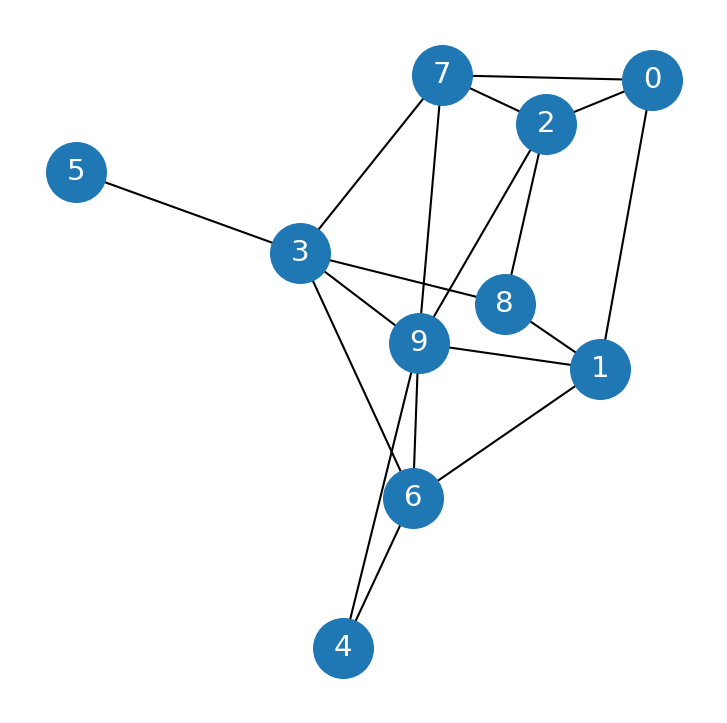

In [3]:
G_dummy = nx.erdos_renyi_graph(n=10, p=0.3, seed=32, directed=False)

plt.figure(figsize=(6, 6), dpi=150)
plt.axis("off")
nx.draw_networkx(G_dummy, pos=nx.spring_layout(G_dummy, seed=32), 
                 font_color="white", font_size=14, node_size=800)
plt.show()

In [4]:
# Biased random walk algorithm
class BiasedRandomWalk:
    def __init__(self, G: nx.Graph, p: int, q: int):
        self.G = G
        self.p = p
        self.q = q

    def calc_next_node(self, previous_node: int, current_node: int) -> int:
        neighbors = list(self.G.neighbors(current_node))
        alphas = list()

        for neighbor in neighbors:
            if neighbor == previous_node:
                alphas.append(1/self.p)
            elif self.G.has_edge(previous_node, neighbor):
                alphas.append(1)
            else:
                alphas.append(1/self.q)

        probs = [alpha / sum(alphas) for alpha in alphas]
        next_node = np.random.choice(neighbors, size=1, p=probs)[0]
        
        return next_node

    def random_walk(self, start: int, length: int) -> List:
        walk = [start]

        for i in range(length):
            current = walk[-1]
            previous = walk[-2] if len(walk) > 1 else None
            next_node = self.calc_next_node(previous, current)
            walk.append(next_node)

        return walk

## - DeepWalk

[0, 1, 8, 2, 7, 9, 2, 7, 3, 9, 7]


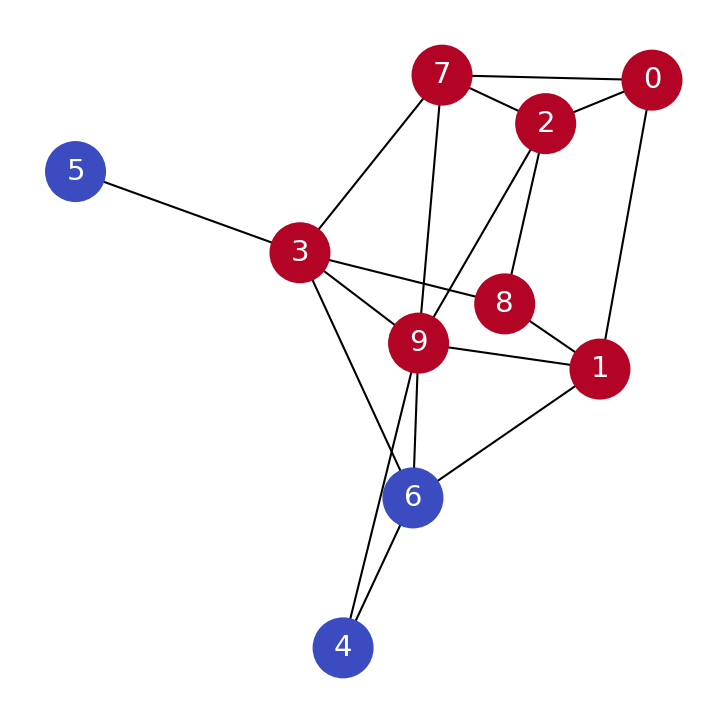

In [5]:
brw = BiasedRandomWalk(G=G_dummy, p=1, q=1)
res = brw.random_walk(0, 10) # Deep Walk
print(res)
node_colors = np.in1d(G_dummy.nodes, res).astype(int)
plt.figure(figsize=(6, 6), dpi=150)
plt.axis("off")
nx.draw_networkx(G_dummy, pos=nx.spring_layout(G_dummy, seed=32), 
                 node_color=node_colors,
                 cmap="coolwarm",
                 font_color="white", font_size=14, node_size=800)
plt.show()

## - Biased Random Focusing on BFS

[0, 7, 2, 7, 0, 7, 0, 2, 7, 2, 9]


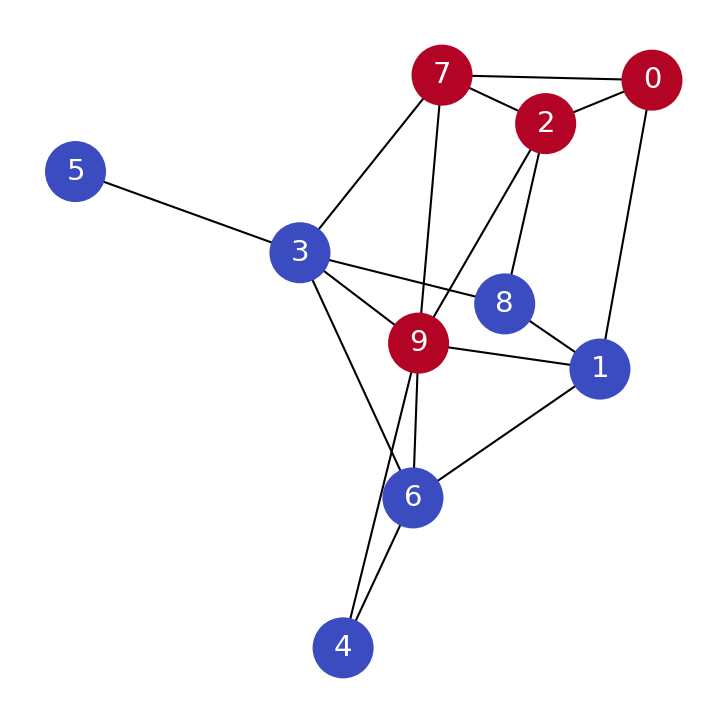

In [6]:
brw = BiasedRandomWalk(G=G_dummy, p=1, q=10)
res = brw.random_walk(0, 10)
print(res)
node_colors = np.in1d(G_dummy.nodes, res).astype(int)
plt.figure(figsize=(6, 6), dpi=150)
plt.axis("off")
nx.draw_networkx(G_dummy, pos=nx.spring_layout(G_dummy, seed=32), 
                 node_color=node_colors,
                 cmap="coolwarm",
                 font_color="white", font_size=14, node_size=800)
plt.show()

## - Biased Random Walk focusing more on DFS

[0, 1, 8, 2, 7, 9, 1, 8, 1, 0, 2]


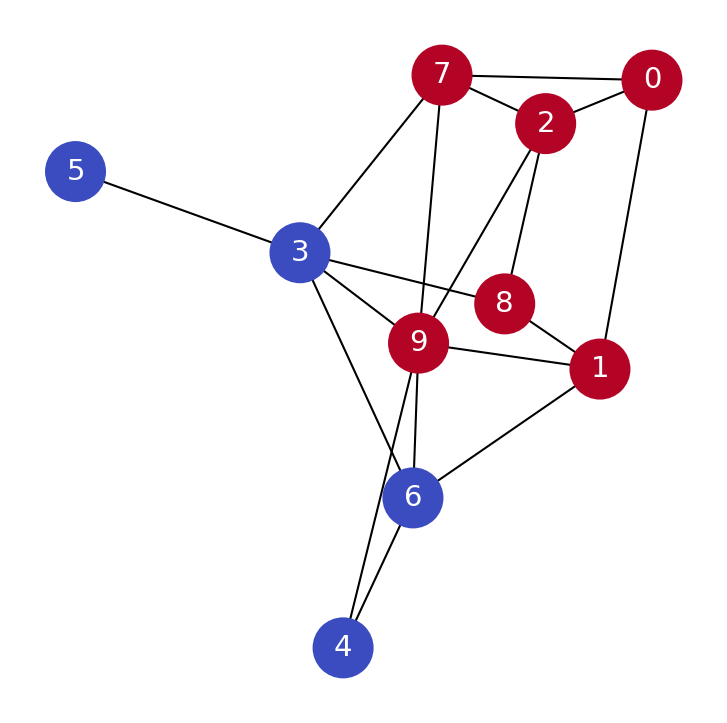

In [7]:
brw = BiasedRandomWalk(G=G_dummy, p=10, q=1)
res = brw.random_walk(0, 10)
print(res)
node_colors = np.in1d(G_dummy.nodes, res).astype(int)
plt.figure(figsize=(6, 6), dpi=150)
plt.axis("off")
nx.draw_networkx(G_dummy, pos=nx.spring_layout(G_dummy, seed=32), 
                 node_color=node_colors,
                 cmap="coolwarm",
                 font_color="white", font_size=14, node_size=800)
plt.show()

> In the above pictures, the nodes marked in **red** are the **nodes visited** using the **random walk** algorithm.

# 3. Implementing Node2Vec

In this part of the notebook, we will implement the Node2Vec algorithm and compare it with the DeepWalk algorithm on the Zachary's Karate club dataset.

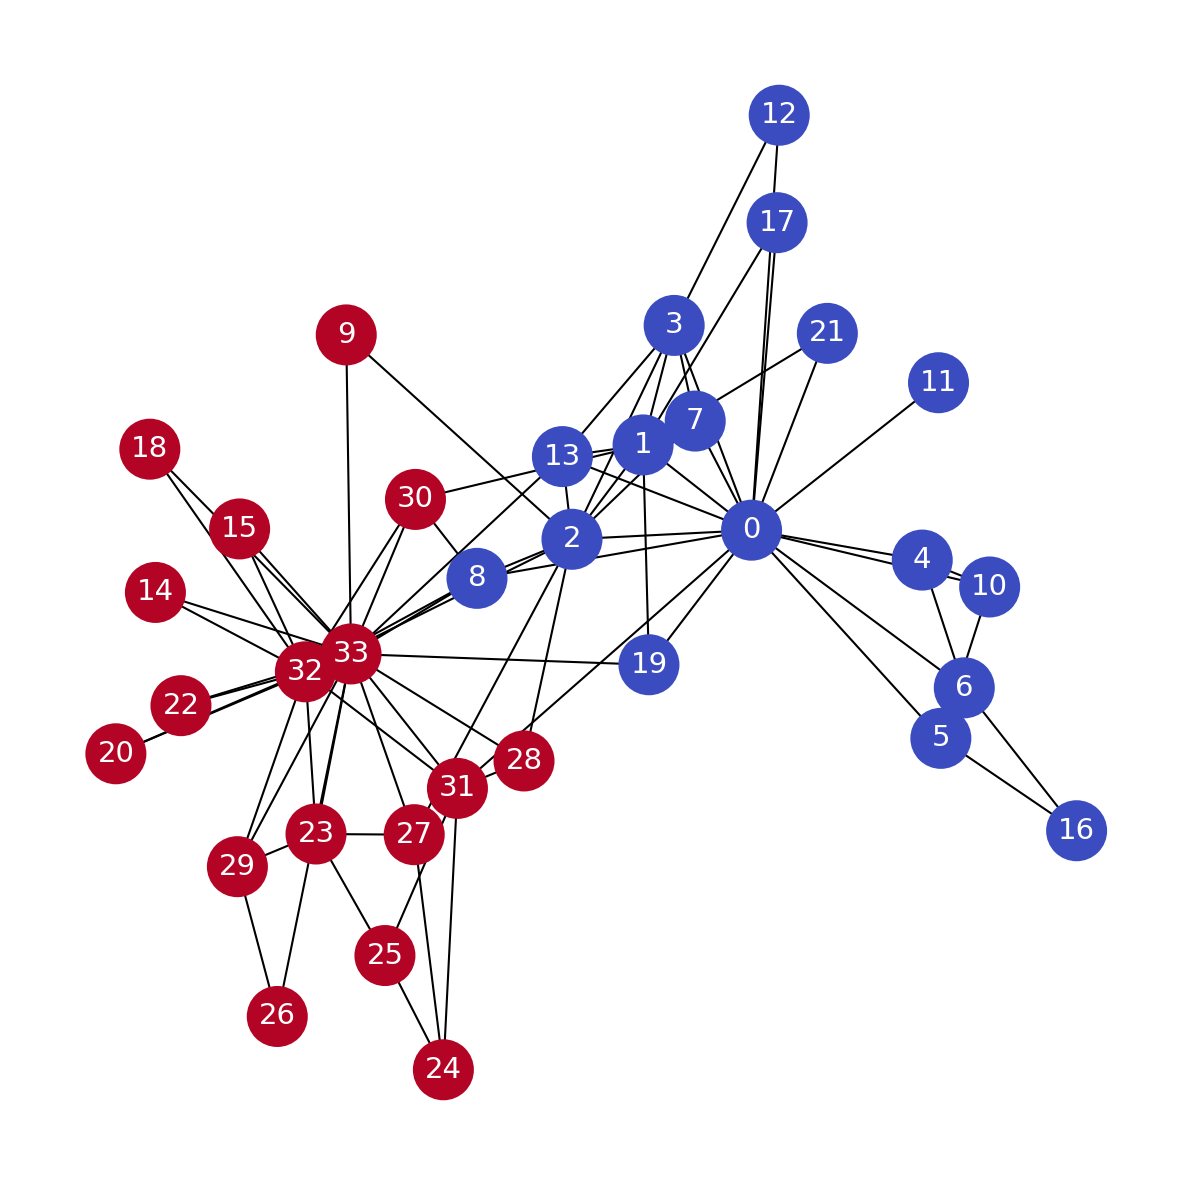

In [8]:
G = nx.karate_club_graph()
labels = [1 if G.nodes[node]["club"] == "Officer" else 0 for node in G.nodes]

plt.figure(figsize=(10, 10), dpi=150)
plt.axis("off")
nx.draw_networkx(G, 
                pos=nx.spring_layout(G, seed=32),
                node_color=labels,
                cmap="coolwarm",
                font_color="white",
                font_size=14,
                node_size=800)

In [9]:
class Experiment:
    def __init__(self, G:nx.Graph, p: int, q: int, n_walks: int, walk_length: int, kfold: int=5, vector_size: int=100, window_size: int=10, epochs: int=30):
        self.G = G
        self.p = p
        self.q = q
        self.n_walks = n_walks
        self.walk_length = walk_length
        self.kfold = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=32)
        self.random_walks = BiasedRandomWalk(G=G, p=p, q=q)
        self.vector_size = vector_size
        self.window_size = window_size
        self.epochs=epochs
        
    def generate_random_walks(self) -> List:
        random_walks = list()
        for node in self.G.nodes:
            for _ in range(self.n_walks):
                walk = self.random_walks.random_walk(node, self.walk_length)
                random_walks.append(walk)
                
        return random_walks

    def calc_vector(self, random_walks) -> Word2Vec:
        node2vec = Word2Vec(random_walks, 
                            hs=1,
                            sg=1,
                            vector_size=self.vector_size,
                            window=self.window_size,
                            min_count=1,
                            seed=32
                           )
        node2vec.train(random_walks, total_examples = node2vec.corpus_count, epochs=self.epochs, report_delay=1)
        return node2vec

    def evaluate_algo(self, node_vec: KeyedVectors, labels: np.ndarray) -> Tuple[float, float]:

        scores = list()
        
        for idx, (train_idx, test_idx) in enumerate(self.kfold.split(node_vec, labels)):
            
            clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=32)
            clf.fit(node_vec[train_idx], labels[train_idx])
            acc = accuracy_score(labels[test_idx], clf.predict(node_vec[test_idx]))

            scores.append(acc)


        return np.mean(scores), np.std(scores)

    def main(self, labels) -> Tuple[float, float]:
        random_walks = self.generate_random_walks()
        node2vec = self.calc_vector(random_walks)
        mean_score, std_score = self.evaluate_algo(node2vec.wv, np.array(labels))

        return mean_score, std_score

In [10]:
# exp = Experiment(G=G, p=1, q=1, n_walks=80, walk_length=10)
# exp.main(labels)

data = dict()

for p in range(1, 8):
    for q in range(1, 8):
        exp = Experiment(G=G, p=p, q=q, n_walks=80, walk_length=10)
        res = exp.main(labels)
        data[str((p, q))] = {"mean_acc": res[0], "std_acc": res[1]}

In [11]:
data

{'(1, 1)': {'mean_acc': 0.9380952380952381, 'std_acc': 0.0761904761904762},
 '(1, 2)': {'mean_acc': 0.9380952380952381, 'std_acc': 0.0761904761904762},
 '(1, 3)': {'mean_acc': 0.9380952380952381, 'std_acc': 0.0761904761904762},
 '(1, 4)': {'mean_acc': 0.9666666666666666, 'std_acc': 0.06666666666666665},
 '(1, 5)': {'mean_acc': 0.9666666666666666, 'std_acc': 0.06666666666666665},
 '(1, 6)': {'mean_acc': 0.9666666666666666, 'std_acc': 0.06666666666666665},
 '(1, 7)': {'mean_acc': 0.9380952380952381, 'std_acc': 0.0761904761904762},
 '(2, 1)': {'mean_acc': 0.9714285714285715, 'std_acc': 0.05714285714285716},
 '(2, 2)': {'mean_acc': 0.9380952380952381, 'std_acc': 0.0761904761904762},
 '(2, 3)': {'mean_acc': 0.9666666666666666, 'std_acc': 0.06666666666666665},
 '(2, 4)': {'mean_acc': 0.9666666666666666, 'std_acc': 0.06666666666666665},
 '(2, 5)': {'mean_acc': 0.9666666666666666, 'std_acc': 0.06666666666666665},
 '(2, 6)': {'mean_acc': 0.9380952380952381, 'std_acc': 0.0761904761904762},
 '(2,

The values for the key $(1, 1)$ represents **DeepWalk algorithm** performance on the Karate club dataset, and the rest represents the performance of the **Node2Vec** algorithm on the Karate Club dataset. While most of the results of the Node2Vec matches with the results from DeepWalk, the underlying cause for this is because of the dataset size, for it being so small. Also, we didn't try what happens when we change the embeddings dimension or window size. Guess it's upto you now to try and see what the results are when those two factors are also changed. 

One thing which we can observe that for high value of $p$ the accuracy score is better. This suggest that in a social network setting, biasing our random walk more towards **homophily** is a **good strategy**.

# 3. Building Recommender System for the MovieLens dataset

So in this section of the notebook we will build a recommender dataset for the MovieLens dataset using the Node2Vec algorithm.

In [12]:
df_ratings = pd.read_csv("../data/ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "unix_timestamp"])
df_ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
df_movies = pd.read_csv("../data/ml-100k/u.item", sep="|", names=["movie_id", "title"], usecols=range(2), encoding="latin-1")
df_movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [14]:
print(f"Shape of the ratings dataset: {df_ratings.shape}")
print(f"Shape of the movies dataset: {df_movies.shape}")

Shape of the ratings dataset: (100000, 4)
Shape of the movies dataset: (1682, 2)


In [15]:
df_ratings["rating"].value_counts()

rating
4    34174
3    27145
5    21201
2    11370
1     6110
Name: count, dtype: int64

Now we don't want any movies with a movie rating less than 4 as the whole point of the recommendation system is to provide great movies. Thus let's remove those bad movies.

In [16]:
df_ratings = df_ratings[df_ratings["rating"] >= 4]
print(f"Shape of the ratings dataset: {df_ratings.shape}")

Shape of the ratings dataset: (55375, 4)


In [17]:
print(f"Number of users now: {df_ratings["user_id"].nunique()}")

Number of users now: 942


Now we will want to count every time two movies that are liked by the same user. And we will repeat this process for every user in the dataset.

In [18]:
pairs = defaultdict(int)

for grp in df_ratings.groupby(by="user_id"):
    user_movies = list(grp[1]["movie_id"])
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

Let's build a graph on these pairs.

> Disclaimer: we will add an edge between two nodes if the score is $\geq 10$ else there is no point of creating an edge because that would create a graph which is large with less meaningful connections.

In [117]:
edge_data = list()

for pair in pairs:
    m1, m2 = pair
    score = pairs[pair]

    if score >= 20:
        edge_data.append((m1, m2, score))

In [128]:
G = fnode2vec.Graph(edges=edge_data, directed=False, weighted=True)

n2v = fnode2vec.Node2Vec(G, dim=64, walk_length=20, window=10, p=2, q=.5, workers=2, seed=32, batch_walks=200)

Reading graph:   0%|                                  | 0/24139 [00:00<?, ?it/s]

In [129]:
n2v.train(epochs=100)

Epochs:   0%|                                           | 0/100 [00:00<?, ?it/s]

In [130]:
def recommend(movie_name: str):
    movie_id = df_movies[df_movies["title"] == movie_name]["movie_id"].values
    if len(movie_id):
        movie_id = movie_id[0]
        for vals in n2v.wv.most_similar(positive=movie_id, topn=5):
            idx, score = vals
            title = df_movies[df_movies["movie_id"] == idx]["title"].values[0]
            print(f"{idx}| {title} : {score:.3f}")

In [135]:
recommend("Get Shorty (1995)")

458| Nixon (1995) : 0.659
1028| Grumpier Old Men (1995) : 0.659
235| Mars Attacks! (1996) : 0.653
381| Muriel's Wedding (1994) : 0.650
252| Lost World: Jurassic Park, The (1997) : 0.650
